In [1]:
import preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
import sqlite3
import seaborn as sns
import graphviz 
import matplotlib.pyplot as plt

In [2]:
filePath="./data/financial.db"
# dataframe = preprocessing.loadAllData(filePath)

In [13]:
def extractXYValues(df, yVectorName):
    notNanDF = df[ df[yVectorName].notna() ]
    yValues = notNanDF[yVectorName]
    xValues = notNanDF.loc[:, notNanDF.columns != yVectorName] 

    one_hot_Xdata = pd.get_dummies(xValues)

    return (one_hot_Xdata, yValues)

def getTrainTestSplit(xValues, yValues): 
    X_train, X_test, y_train, y_test = train_test_split(xValues, yValues, test_size=0.30)

    return (X_train, X_test, y_train, y_test)

def accChangeToDemo(filepath):
    """
        Creates column to be added to demographic table. Column is taken from the 
        summed difference of the median account balances by district (1994-1998)
        relative to the median account value in all data in 1994.
    Args:
        filepath (str): path to financial.db.
    """
    conn = sqlite3.connect(filepath)
    accdist = pd.read_sql_query("SELECT account_id, district_id from account", conn)
    df = pd.read_sql_query("SELECT date as 'y-m-d', balance, account_id from trans ", conn)
    from datetime import date
    df['y-m-d'] = pd.to_datetime(df['y-m-d'])
    df['year'] = df['y-m-d'].map(lambda x: x.strftime('%Y'))
    df = pd.merge(accdist, df, on='account_id')
    
    # Gets the average value of each account per id per district per year
    acctMedianPerAcctPerYearPerDistrict = df.groupby(['year', 'district_id', 'account_id'])[['balance']].median()

    # Calculates median/average account balance of each district per year
    medianAcct = acctMedianPerAcctPerYearPerDistrict.groupby(['year', 'district_id'])[['balance']].median()
    avgAcct = acctMedianPerAcctPerYearPerDistrict.groupby(['year', 'district_id'])[['balance']].mean()
    
    
    # Gets difference of each account's median per year
#     districtchange = average.groupby(['district_id'])[['balance']].diff().fillna(0)
#     asum = districtchange.groupby(['district_id'])[['balance']].sum()
#     newdemo = asum.div(302.70801242)

    return (acctMedianPerAcctPerYearPerDistrict.reset_index(), medianAcct.reset_index(), avgAcct.reset_index()) 

def categorizeGrowth(growthRate): 
    if growthRate > 10: 
        return 0
    elif growthRate >= 0: 
        return 1
    elif growthRate >= -10:
        return 2
    else: 
        return 3


def doKfoldCrossValidation(X,y, model, isRegression):     
    kf = KFold(n_splits=5, random_state=None, shuffle=True)
    errorRates = []
    for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
        X_train, X_test = X[train_index, :], X[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        mlModel = model()
        mlModel.fit(X_train, y_train)
        y_test_pred = mlModel.score(X_test, y_test)
        # Save off y_test_pred in a list or something -- you can average it all when done
        
#         if isRegression: 
#             errorRates.append( np.mean(np.abs(y_test.reshape((len(y_test),)) - y_test_pred) ))
#         else: 
#             errorRates.append( np.sum(y_test.reshape((len(y_test),)) == y_test_pred)/len(y_test_pred) )
        errorRates.append(y_test_pred)

    return np.mean(errorRates)


def getDataFrame(filePath): 
    (acctMedianPerAcctPerYearPerDistrict, medianPerDistrictDF, averagePerDistrictDF) = accChangeToDemo(filePath)
    conn = sqlite3.connect(filePath)
    districtDFNoNames = pd.read_sql_query("SELECT * from district", conn)
    districtDFNoNames.at[68,'A12'] = districtDFNoNames.at[68,'A13'] 
    districtDFNoNames.at[68,'A15'] = districtDFNoNames.at[68,'A16']
    
    conn.close()
    districtDF = updateColumnNames(districtDFNoNames)
    districtDF.drop(['districtName', 'region'], axis=1, inplace=True)
    
    dfAccts = districtDF.merge(acctMedianPerAcctPerYearPerDistrict, on=["district_id"])
    medianPerDistAccts = districtDF.merge(medianPerDistrictDF, on=["district_id"])
    meanPerDistAccts =  districtDF.merge(averagePerDistrictDF, on=["district_id"])

    return (dfAccts,medianPerDistAccts,meanPerDistAccts)

def getAccuracy(X,y, model, isRegression): 
    xTrain, xTest, yTrain, yTest = getTrainTestSplit(X,y)
    modelObject = model()
    modelObject.fit(xTrain, yTrain)
    yPredicted = modelObject.predict(xTest)
    
    if isRegression: 
        return (modelObject, metrics.mean_squared_error(yTest, yPredicted))
    else:
        return (modelObject, metrics.accuracy_score(yTest,yPredicted))


def applyModelToDataframe(df, xColumnsArray, yVectorName, model, isRegression, classifierType='linear'): 

    X = df[xColumnsArray].values
    y = df[yVectorName].values.reshape((len(df[yVectorName],)))

    kFoldAccuracy = doKfoldCrossValidation(X,y, model, isRegression)
    (modelObject, accuracy) = getAccuracy(X,y, model, isRegression)
    
    if classifierType=='randomForest':
        printImportance(modelObject, X)
    elif classifierType == 'decisionTree': 
        plt.figure(figsize=(15,15)) 
        plot_tree(modelObject, fontsize=12)
        plt.show()
    
    return (kFoldAccuracy, accuracy)

def updateColumnNames(df): 
    columnNames = ['district_id','districtName','region', 'numInhabitants', 
                   'municipalitiesLess500','municipalities500to2k','municipalities2kto10k',
                   'municipalitiesGreater10k','numCities','ratioUrbanInhabitants','avgSalary',
                   'unEmployment95','unEmployment96','entrepeneursPer1k','crimesIn95','crimesIn96' ] 
    df.columns = columnNames
        
    return df

def printImportance(model, X): 
    importances = model.feature_importances_
    std = np.std([model.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the impurity-based feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
            color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()

In [4]:
dfAcct, medianPerDistrict, meanPerDistrict = getDataFrame(filePath)
allXColumns = ['district_id','numInhabitants', 'municipalitiesLess500','municipalities500to2k','municipalities2kto10k','municipalitiesGreater10k','numCities',                   
           'ratioUrbanInhabitants','avgSalary','unEmployment95','unEmployment96', 'entrepeneursPer1k', 'crimesIn95', 'crimesIn96' ] 
yVector = ['balance']

Feature ranking:
1. feature 8 (0.125094)
2. feature 1 (0.112003)
3. feature 11 (0.100703)
4. feature 10 (0.099965)
5. feature 9 (0.085795)
6. feature 2 (0.070249)
7. feature 0 (0.068632)
8. feature 7 (0.066668)
9. feature 12 (0.066421)
10. feature 6 (0.050185)
11. feature 4 (0.049043)
12. feature 3 (0.042041)
13. feature 13 (0.041730)
14. feature 5 (0.021473)


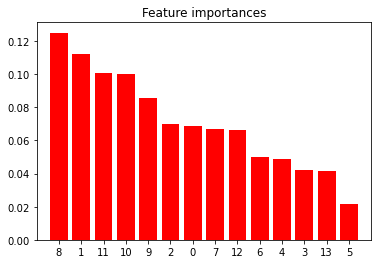

(0.0003637287398854161, 299816573.8262462)

In [14]:
randomForestAccuracy = applyModelToDataframe(dfAcct, allXColumns, yVector, RandomForestRegressor, True, 'randomForest')
randomForestAccuracy

Feature ranking:
1. feature 2 (0.116193)
2. feature 4 (0.113849)
3. feature 7 (0.094340)
4. feature 8 (0.075512)
5. feature 3 (0.073432)
6. feature 12 (0.073236)
7. feature 0 (0.068576)
8. feature 13 (0.066222)
9. feature 9 (0.059743)
10. feature 10 (0.059366)
11. feature 1 (0.056518)
12. feature 11 (0.051922)
13. feature 6 (0.049130)
14. feature 5 (0.041959)


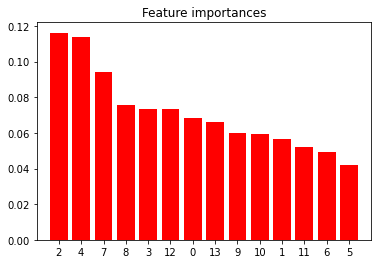

(0.03730016914958545, 16926161.92358963)

In [15]:
randomForestAccuracy = applyModelToDataframe(medianPerDistrict, allXColumns, yVector, RandomForestRegressor, True, 'randomForest')
randomForestAccuracy

Feature ranking:
1. feature 11 (0.143064)
2. feature 2 (0.119780)
3. feature 0 (0.085820)
4. feature 3 (0.078066)
5. feature 10 (0.074159)
6. feature 4 (0.071058)
7. feature 8 (0.070504)
8. feature 1 (0.069155)
9. feature 7 (0.068852)
10. feature 9 (0.056882)
11. feature 12 (0.053595)
12. feature 6 (0.042829)
13. feature 13 (0.042160)
14. feature 5 (0.024077)


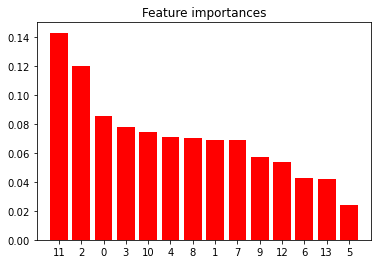

(-0.11113053519341594, 15611733.77911248)

In [16]:
randomForestAccuracy = applyModelToDataframe(meanPerDistrict, allXColumns, yVector, RandomForestRegressor, True, 'randomForest')
randomForestAccuracy

In [17]:
linearRegressionAccuracy = applyModelToDataframe(dfAcct, allXColumns, yVector, LinearRegression, True)
linearRegressionAccuracy

(-0.000279008871549502, 287503300.9527799)

In [18]:
balanceRatioSalary = ['balance'] 
yVector = ['district_id']

In [19]:
randomForestClassificationDfAcct = applyModelToDataframe(dfAcct, balanceRatioSalary, yVector, RandomForestClassifier, False )
randomForestClassificationMedian = applyModelToDataframe(medianPerDistrict, balanceRatioSalary, yVector, RandomForestClassifier, False  )
randomForestClassificationMean = applyModelToDataframe(meanPerDistrict, balanceRatioSalary, yVector, RandomForestClassifier, False  )

In [20]:
print(f"""
randomForestClassificationDfAcct {randomForestClassificationDfAcct}
randomForestClassificationMedian {randomForestClassificationMedian}
randomForestClassificationMean {randomForestClassificationMean}
""")


randomForestClassificationDfAcct (0.029579193591732778, 0.02944528875379939)
randomForestClassificationMedian (0.008695652173913044, 0.050359712230215826)
randomForestClassificationMean (0.004347826086956522, 0.0)



In [21]:
someData = preprocessing.loadAllData(filePath, True)

In [22]:
loanDF = someData[someData['status'].notna()].drop(['card_id', 'type_y', 'issued', 'date_y', 'date_x', 'issued', 'type_y', 'issued'], axis=1)
loanDF[loanDF['district_id' ]==15]

,account_id,district_id,frequency,disp_id,client_id,type_x,gender,birth_date,district_id_y,loan_id,...,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
856,314,15,2,383,383,0,0,-9.665424e+08,15,5039.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879
857,314,15,2,384,384,1,1,-1.080328e+09,15,5039.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879
906,4825,15,0,5826,5826,0,1,-4.137120e+07,15,5980.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879
907,4825,15,0,5827,5827,1,0,1.601172e+08,15,5980.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879
908,5283,15,0,6383,6383,0,1,5.364000e+05,15,6078.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879
910,5572,15,0,6729,6729,0,1,-3.791052e+08,15,6136.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879
911,5593,15,0,6753,6753,0,1,-2.401776e+08,15,6144.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879
912,5927,15,0,7166,7166,0,1,-1.778832e+08,15,6210.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879
915,11265,15,0,13537,13845,0,1,9.868680e+07,15,7284.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879


In [23]:
for column in loanDF.columns: 
    if len(loanDF[loanDF[column].isna()]) > 0: 
        print(column)

In [24]:
accuracy=applyModelToDataframe(loanDF, ['account_id', 'district_id', 'frequency', 'disp_id', 'client_id',
       'type_x', 'gender', 'birth_date', 'district_id_y', 'loan_id', 'amount',
       'duration', 'payments', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8',
       'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16'], ['status'], RandomForestClassifier, False)
accuracy

(0.7437020810514786, 0.7108433734939759)

Feature ranking:
1. feature 10 (0.149363)
2. feature 9 (0.117426)
3. feature 11 (0.086155)
4. feature 8 (0.061855)
5. feature 3 (0.058345)
6. feature 4 (0.058032)
7. feature 7 (0.055504)
8. feature 0 (0.053121)
9. feature 15 (0.028798)
10. feature 20 (0.028358)
11. feature 13 (0.027345)
12. feature 23 (0.026422)
13. feature 25 (0.025059)
14. feature 22 (0.024395)
15. feature 24 (0.024245)
16. feature 1 (0.023428)
17. feature 21 (0.022646)
18. feature 14 (0.022396)
19. feature 16 (0.019314)
20. feature 19 (0.019308)
21. feature 18 (0.017568)
22. feature 2 (0.013565)
23. feature 12 (0.012052)
24. feature 17 (0.010241)
25. feature 6 (0.010217)
26. feature 5 (0.004843)


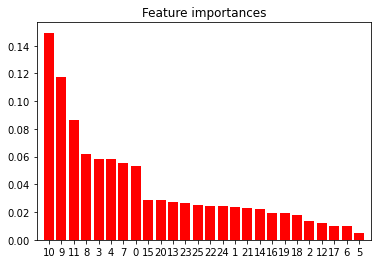

In [25]:
xCols = ['account_id', 'district_id', 'frequency', 'disp_id', 'client_id',
       'type_x', 'gender', 'birth_date', 'loan_id', 'amount',
       'duration', 'payments', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8',
       'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16']
yCol = [ 'status' ]

acc = applyModelToDataframe(loanDF, xCols, yCol, RandomForestClassifier, False, 'randomForest')

Feature ranking:
1. feature 0 (1.000000)


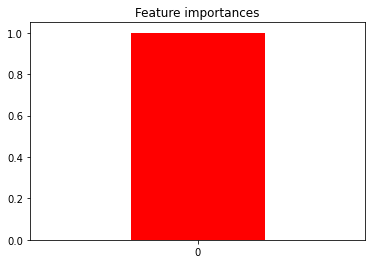

(0.7146695874406717, 0.7309236947791165)

In [26]:
acc = applyModelToDataframe(loanDF, ['duration'], yCol, RandomForestClassifier, False, 'randomForest')
acc

In [27]:
X = np.array(xCols)
higherAccCols = X[[10,9,11,7,0,3,8,4]]

Feature ranking:
1. feature 0 (0.192735)
2. feature 1 (0.163293)
3. feature 2 (0.134832)
4. feature 7 (0.106574)
5. feature 3 (0.106212)
6. feature 5 (0.100877)
7. feature 6 (0.099370)
8. feature 4 (0.096107)


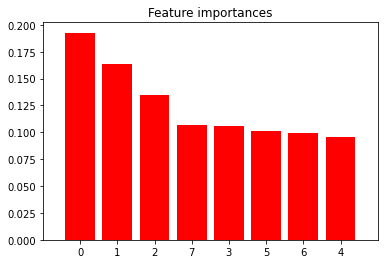

In [28]:
yCol = [ 'status' ]
acc = applyModelToDataframe(loanDF, higherAccCols, yCol, RandomForestClassifier, False, 'randomForest')

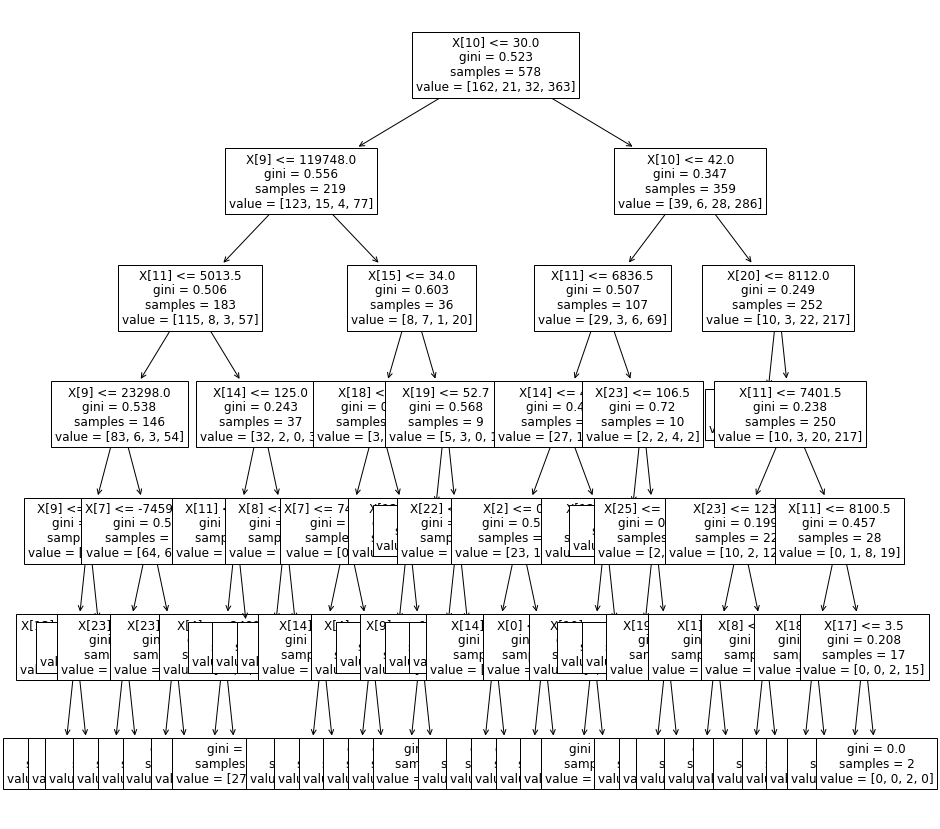

In [29]:
acc = applyModelToDataframe(loanDF, xCols, yCol, lambda: DecisionTreeClassifier(max_depth=6), False, 'decisionTree')


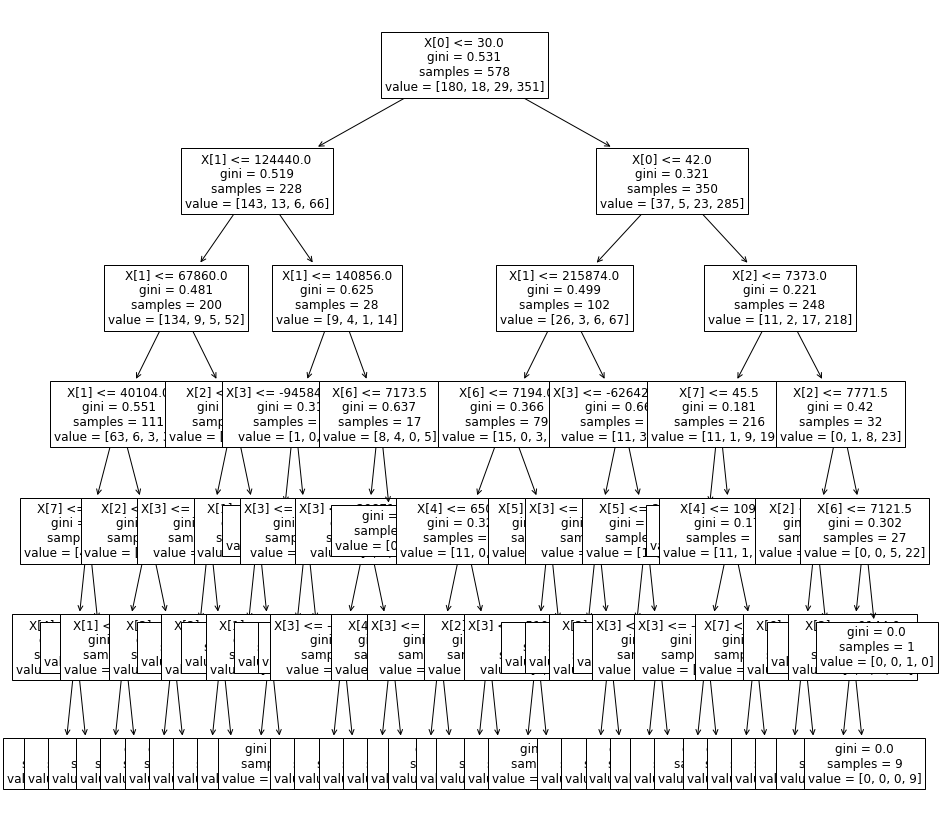

(0.7218400876232202, 0.6546184738955824)

In [30]:
acc = applyModelToDataframe(loanDF, higherAccCols, yCol, lambda: DecisionTreeClassifier(max_depth=6), False, 'decisionTree')
acc

In [31]:
acc = applyModelToDataframe(loanDF, xCols, yCol, lambda: KNeighborsClassifier(n_neighbors=400), False)
acc

(0.5962468054034319, 0.5863453815261044)